In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.8 MB/s eta 0:00:00


In [ ]:
!unzip 'drive/MyDrive/Tinkoff/Лаба/CCPD2019-dl1.zip'

In [ ]:
import torch
from torch import nn
from torch import functional as F
from torchmetrics import CharErrorRate
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import cv2
from os import listdir
from os.path import isfile, join
from pathlib import Path
from tqdm.notebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [ ]:
TEST_PATH = 'CCPD2019-dl1/test/'
TRAIN_PATH = 'CCPD2019-dl1/train/'
MODEL_PATH = 'drive/MyDrive/Tinkoff/Лаба/model.pth'
BATCH_SIZE = 64
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 64
EPOCHS=5
SEQ_LENGTH = 7
OUTP_SEQ_LENGTH = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

ALPHABET_LENGTH = len(set(provinces + alphabets + ads)) + 1
BLANK_IDX = 0

letters = list(set(provinces + alphabets + ads))

##Подготовка данных

In [ ]:
ids_to_letters = {index + 1: letter for index, letter in enumerate(letters)}
ids_to_letters[BLANK_IDX] = '-'
letters_to_ids = {letter: index + 1 for index, letter in enumerate(letters)}
letters_to_ids['-'] = BLANK_IDX

In [ ]:
def encode_label(label: str) -> list:
    '''Encodes a license plate

    Args:
        label: input license plate
    
    Returns:
        list: encoded tokens
    '''
    encoded_label = [letters_to_ids[letter] for letter in label]
    return encoded_label

def decode_label(ids: np.array) -> str:
    '''Decodes a license plate

    Args:
        label: array of tokens
    
    Returns:
        list: decoded license plate
    '''
    label = [ids_to_letters[index] for index in ids if index != BLANK_IDX] #  if index != BLANK_IDX
    label = ''.join(label)
    return label

In [ ]:
# !unzip 'drive/MyDrive/Tinkoff/Лаба/CCPD2019-dl1.zip' -d 'drive/MyDrive/Tinkoff/Лаба/data'

In [ ]:
class Dataset(torch.utils.data.Dataset):
    '''Train and test dataset

    Args:
        path: data path
        transforms: data transformations
    '''
    def __init__(self, path: str, 
                 transforms: A.Compose):
        
        self.files = [path + f for f in listdir(path) if isfile(join(path, f))]
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, index: int) -> tuple:
        image_file = self.files[index]
        image = cv2.imread(image_file)
        label = Path(image_file).stem.split('-')[1].upper()
        X = self.transforms(image=image)['image'] #/ 256
        y = encode_label(label)
        return torch.FloatTensor(X), torch.tensor(y)

In [ ]:
transforms = A.Compose([A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = Dataset(TRAIN_PATH, transforms)

In [ ]:
test_dataset = Dataset(TEST_PATH, transforms)

In [ ]:
def collate_fn(batch: tuple) -> tuple:
    '''Transforms a batch

    Args:
        batch: input batch
    
    Returns:
        list: transformed batch
    '''
    x = [i[0].permute(2, 0, 1).numpy() for i in batch]
    y = [i[1].numpy() for i in batch]
    return torch.tensor(x), torch.tensor(y)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          collate_fn=collate_fn, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [ ]:
next(iter(train_loader))[0].shape

<ipython-input-12-3d3033e18a70>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(x), torch.tensor(y)


torch.Size([64, 3, 64, 128])

In [ ]:
len(train_loader)

3124

##Создание и обучение модели

In [ ]:
class FCNN(nn.Module):
    '''Fully-convolutional CNN'''

    def __init__(self):
        super().__init__()

        # 3x64x128
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, 
                      kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 16x32x64
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 32x16x32
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(4, 1))
        )

        # 64x4x32
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x2x16
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        )

        # 128x1x16
        self.flatten = nn.Flatten(2)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(x).permute(0, 2, 1) # batch x outp_seq_length (16) x hidden_size (128)

class BiLSTM(nn.Module):
    '''Bidirectional LSTM

    Args:
        input_size: size of input tensor (is equal to the FCNN hidden size)
        hidden_size: hidden size of lstm
        out_size: alphabet_size
    '''

    def __init__(self, input_size: int, hidden_size: int, out_size: int):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            bidirectional=True, batch_first=False)
        self.fc1 = nn.Linear(in_features=hidden_size * 2, out_features=out_size)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        hidden_state, _ = self.lstm(x)
        x = self.fc1(hidden_state)
        return x

class Model(nn.Module):
    '''Bidirectional LSTM

    Args:
        input_size: size of BiLSTM input tensor (is equal to the FCNN hidden size)
        hidden_size: hidden size of BiLSTM
        out_size: alphabet_size
    '''
    
    def __init__(self, input_size: int=128, 
                 lstm_hidden_size: int=128, 
                 output_size: int=ALPHABET_LENGTH):
        
        super().__init__()
        self.fcnn = FCNN()
        self.lstm = BiLSTM(input_size=input_size, 
                           hidden_size=lstm_hidden_size, 
                           out_size=output_size)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        fcnn = self.fcnn(x)
        lstm = self.lstm(fcnn)
        return lstm  # batch x outp_seq_length x alphabet

In [ ]:
def get_num(predictions: torch.tensor) -> list:
    '''Transforms model's predictions to license plates

    Args:
        predictions: model's predictions
    
    Returns:
        list: license plates
    '''

    predictions = predictions.argmax(-1)
    indices = torch.unique_consecutive(predictions, dim=-1)
    strings = [decode_label(sample.cpu().detach().numpy()) for sample in indices]
    return strings

In [ ]:
def accuracy(predictions: torch.tensor, y: torch.tensor) -> float:
    '''Calculates the proportion of correct license plates (accuracy score)

    Args:
        predictions: model's predictions
        y: correct license plates
    
    Returns:
        float: accuracy score
    '''
    
    nums = np.array(get_num(predictions))
    y = np.array([decode_label(sample.cpu().detach().numpy()) for sample in y])
    return (nums == y).sum()

In [ ]:
def char_error_rate(predictions: torch.tensor, y: torch.tensor) -> tuple:
    '''Calculates the proportion of incorrect symbols in a license plate (CER)

    Args:
        predictions: model's predictions
        y: correct license plates
    
    Returns:
        float: CER
        list: calculated CERs for each license plate
    '''

    cer = CharErrorRate()
    nums = np.array(get_num(predictions))
    y = np.array([decode_label(sample.cpu().detach().numpy()) for sample in y])
    sum_cer = 0
    cer_list = []
    for index in range(nums.shape[0]):
        # print(nums[index], y[index])
        error = cer(nums[index], y[index]).item()
        sum_cer += error
        cer_list.append(error)

    return sum_cer, cer_list

In [ ]:
# Подсчет метрик

cur_loss = 1000
def evaluate(model: nn.Module, 
             val_loader: torch.utils.data.dataloader.DataLoader,
             criterion: nn.modules.loss.CTCLoss,
             device: str=DEVICE) -> tuple:
    '''Evaluates the model's quality

    Args:
        model: Model
        val_loader: evaluation data
        criterion: loss
        device: active device
    
    Returns:
        float: evaluation loss
        float: evaluation accuracy
        float: evaluation CER
    '''

    global cur_loss
    val_loss = 0
    accuracy_score = 0
    cer_score = 0
    count = 0
    with torch.no_grad():
        model.eval()
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            val_loss += criterion(preds.permute(1, 0, 2).log_softmax(-1), y, 
                                torch.IntTensor([OUTP_SEQ_LENGTH] * len(preds)), 
                                torch.IntTensor([SEQ_LENGTH] * len(y))).item()
            accuracy_score += accuracy(preds, y)
            cer_score += char_error_rate(preds, y)[0]
            count += len(X)
    print(get_num(preds))
    print(np.array([decode_label(sample.cpu().detach().numpy()) for sample in y]))

    if (cur_loss > val_loss / len(val_loader)):
        torch.save(model, MODEL_PATH)
        cur_loss = val_loss / len(val_loader)

    return val_loss / len(val_loader), accuracy_score / count, cer_score / count

In [ ]:
def train(model: nn.Module, 
          train_loader: torch.utils.data.dataloader.DataLoader,
          criterion: nn.modules.loss.CTCLoss,
          optim: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler.StepLR, 
          num_epochs: int=EPOCHS, 
          device: str=DEVICE) -> list:
    '''Model training cycle

    Args:
        model: Model
        train_loader: training data
        criterion: loss
        optim: optimizer
        scheduler: scheduler
        num_epochs: number of training epochs
        device: active device
    
    Returns:
        list: training losses
    '''

    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for X, y in tqdm(train_loader):
            optim.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            loss = criterion(preds.permute(1, 0, 2).log_softmax(-1), y, 
                            torch.IntTensor([OUTP_SEQ_LENGTH] * len(preds)), 
                            torch.IntTensor([SEQ_LENGTH] * len(y)))
            loss.backward()
            optim.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        scheduler.step()
        val_loss, accuracy_score, cer_score = evaluate(model, test_loader, criterion)
        print(f'train_loss = {round(train_loss / len(train_loader), 3)}', end='  ')
        print(f'val_loss = {round(val_loss, 3)}', end='  ')
        print(f'accuracy = {round(accuracy_score, 3)}', end=' ')
        print(f'CER = {round(cer_score, 3)}', end='\n')

    return train_losses

In [ ]:
model = Model()
model.to(DEVICE)
criterion = nn.CTCLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.3)

In [ ]:
losses = train(model, train_loader, criterion, optim, scheduler)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3124 [00:00<?, ?it/s]

['皖AX192F', '皖AV880W', '皖AD159U', '皖AH9583', '皖AGP822', '皖AU699W', '皖AR222V', '皖AN9R99', '皖GLH055', '皖AM6H80', '皖FFR686', '皖AB8J58', '苏FE56677W', '皖AX0A96', '皖AZA396']
['皖AX192F' '皖AV880W' '皖AD159U' '皖AH9583' '皖AGP822' '皖AU699W' '皖AR222V'
 '皖AN9R99' '皖GLH055' '皖AM6H80' '皖FFR686' '皖AB8J58' '苏BE767W' '皖AX0A96'
 '皖AZA396']
train_loss = 0.138  val_loss = 0.02  accuracy = 0.971 CER = 0.005


  0%|          | 0/3124 [00:00<?, ?it/s]

['皖AX192F', '皖AV880W', '皖AD159U', '皖AH9583', '皖AGP822', '皖AU699W', '皖AR222V', '皖AN9R99', '皖GLH055', '皖AM6H80', '皖FFR686', '皖AB8J58', '皖AE77W', '皖AX0A96', '皖AZA396']
['皖AX192F' '皖AV880W' '皖AD159U' '皖AH9583' '皖AGP822' '皖AU699W' '皖AR222V'
 '皖AN9R99' '皖GLH055' '皖AM6H80' '皖FFR686' '皖AB8J58' '苏BE767W' '皖AX0A96'
 '皖AZA396']
train_loss = 0.004  val_loss = 0.017  accuracy = 0.975 CER = 0.004


  0%|          | 0/3124 [00:00<?, ?it/s]

['皖AX192F', '皖AV880W', '皖AD159U', '皖AH9583', '皖AGP822', '皖AU699W', '皖AR222V', '皖AN9R99', '皖GLH055', '皖AM6H80', '皖FFR686', '皖AB8J58', '皖ME7677T', '皖AX0A96', '皖AZA396']
['皖AX192F' '皖AV880W' '皖AD159U' '皖AH9583' '皖AGP822' '皖AU699W' '皖AR222V'
 '皖AN9R99' '皖GLH055' '皖AM6H80' '皖FFR686' '皖AB8J58' '苏BE767W' '皖AX0A96'
 '皖AZA396']
train_loss = 0.001  val_loss = 0.011  accuracy = 0.982 CER = 0.003


  0%|          | 0/3124 [00:00<?, ?it/s]

['皖AX192F', '皖AV880W', '皖AD159U', '皖AH9583', '皖AGP822', '皖AU699W', '皖AR222V', '皖AN9R99', '皖GLH055', '皖AM6H80', '皖FFR686', '皖AB8J58', '苏FE76677W', '皖AX0A96', '皖AZA396']
['皖AX192F' '皖AV880W' '皖AD159U' '皖AH9583' '皖AGP822' '皖AU699W' '皖AR222V'
 '皖AN9R99' '皖GLH055' '皖AM6H80' '皖FFR686' '皖AB8J58' '苏BE767W' '皖AX0A96'
 '皖AZA396']
train_loss = 0.001  val_loss = 0.012  accuracy = 0.982 CER = 0.003


  0%|          | 0/3124 [00:00<?, ?it/s]

['皖AX192F', '皖AV880W', '皖AD159U', '皖AH9583', '皖AGP822', '皖AU699W', '皖AR222V', '皖AN9R99', '皖GLH055', '皖AM6H80', '皖FFR686', '皖AB8J58', '皖HE76677W', '皖AX0A96', '皖AZA396']
['皖AX192F' '皖AV880W' '皖AD159U' '皖AH9583' '皖AGP822' '皖AU699W' '皖AR222V'
 '皖AN9R99' '皖GLH055' '皖AM6H80' '皖FFR686' '皖AB8J58' '苏BE767W' '皖AX0A96'
 '皖AZA396']
train_loss = 0.0  val_loss = 0.011  accuracy = 0.984 CER = 0.003


In [ ]:
best_model = torch.load(MODEL_PATH)

###В качестве валидационной выборки использовалась тестовая, т.е. итоговый результат:
* Accuracy 0.984
* CharErrorRate 0.003


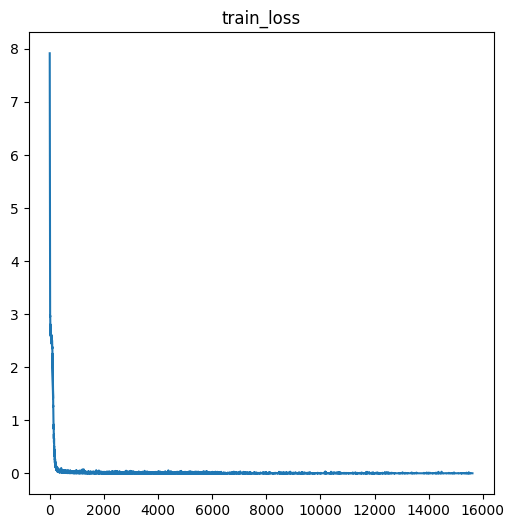

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(losses)
plt.title('train_loss')
plt.show()

##Анализ ошибок модели

In [ ]:
def get_test_cer(model: nn.Module, 
               loader: torch.utils.data.dataloader.DataLoader, 
               device: str=DEVICE) -> pd.DataFrame:
    '''Calculates the CER for each sample of test data

    Args:
        model: Model
        loader: test data
        device: active device
    
    Returns:
        pd.DataFrame: model's predicts, true labels, CER
    '''
    
    errors = []
    predictions = []
    labels = []
    with torch.no_grad():
        model.eval()
        for X, y in tqdm(loader):
            X = X.to(device)
            y = y.to(device)
            model_preds = model(X)
            _, cer_list = char_error_rate(model_preds, y)
            errors += cer_list
            predictions += get_num(model_preds)
            labels += [decode_label(sample.cpu().detach().numpy()) for sample in y]
    
    return pd.DataFrame({'preds': predictions, 
                         'labels': labels, 
                         'cer': errors})

In [ ]:
frame = get_test_cer(best_model, test_loader)

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
frame.sort_values(by=['cer'], ascending=False).head(10)

,preds,labels,cer
6856,皖AR3F,皖AK927W,0.714286
8814,皖AF9P29,皖AF888S,0.571429
9996,皖HE76677W,苏BE767W,0.571429
9824,皖AF1858,皖APY862,0.571429
7334,皖A02T29,皖AD0T89,0.428571
8365,皖AV1640,皖AYU642,0.428571
1027,皖HJ386,皖ABJ356,0.428571
5510,皖A2R353,皖A2W003,0.428571
2840,皖AH76,皖AH767W,0.285714
5984,皖A712V1,鲁M712V1,0.285714


In [ ]:
# видно, что, в основном, модель ошибается в одном символе (1 / 7 = 0.14)
frame['cer'].round(3).value_counts()

0.000    9844
0.143     130
0.286      17
0.429       4
0.571       3
0.714       1
Name: cer, dtype: int64

In [ ]:
# модель ошибается в символах, имеющих общие паттерны (6, 8 и B; D, Q и 0; 2 и Z...)
frame[frame['cer'].round(2) == 0.14].sample(5, random_state=0)

,preds,labels,cer
858,皖AN8666,皖AN866B,0.142857
4878,皖AK0998N,皖AK098N,0.142857
7499,皖AC926R,皖AC928R,0.142857
8326,皖AX134H,皖AY134H,0.142857
8004,皖AL7862,皖AL786Z,0.142857


In [ ]:
warnings.simplefilter(action='ignore')

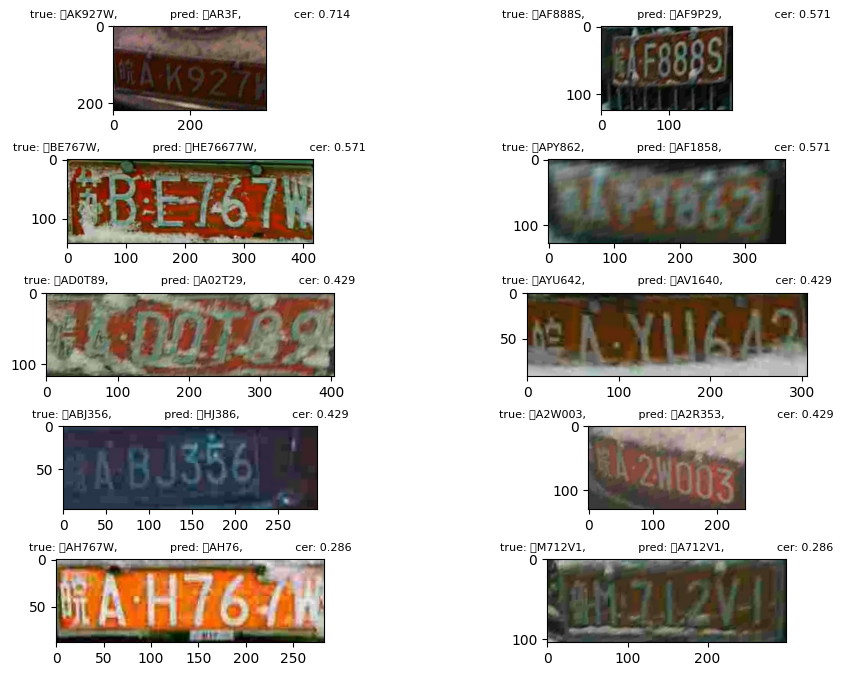

In [ ]:
fig, axes = plt.subplots(5, 2)
plt.subplots_adjust(wspace=0.6, hspace=0.6)
fig.set_size_inches(10, 8)
axes = axes.flatten()

ids = frame.sort_values(by=['cer'], ascending=False).index[:10]

for idx, ax in zip(ids, axes):
    ax.imshow(cv2.imread(test_dataset.files[idx]))
    title = f'true: {frame.loc[idx].labels}, \
              pred: {frame.loc[idx].preds}, \
              cer: {round(frame.loc[idx].cer, 3)}'
    ax.set_title(title, fontsize=8)

### Возможные причины плохого распознаввания:
* Помехи на фотографии (снег, грязь, потертости)
* Плохое качество, размытые фотографии
* Темные фотографии
* Неудачный ракурс, не видно части автомобильного номера

##Итоги

* Модель: имеет предложенную в условии архитектуру 
* Loss: CTCLoss
* Optimizer: Adam
* Scheduler: StepLR
* Tricks: Нормализация изображений

* Test accuracy: 0.984
* Test CER: 0.003